In [1]:
# requires pandas numpy keras tensorflow scikit-learn
# author doesn't explain that he's using jupyter

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 20,10

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

from sklearn.preprocessing import MinMaxScaler

In [3]:
# Understanding the data
df = pd.read_csv("./data/HistoricalData_1649961316573.csv")
df.head()
# Column headers are Date, Close/Last, Volume, Open, High, Low 

,Date,Close/Last,Volume,Open,High,Low
0,04/13/2022,$150.7,2008225,$144.1,$152.13,$142.02
1,04/12/2022,$144.87,1999136,$146.5,$152.25,$141.665
2,04/11/2022,$146.93,2452979,$143.04,$148.22,$140.61
3,04/08/2022,$146.19,2592879,$149.09,$150.7106,$142.03
4,04/07/2022,$150,3827847,$154.11,$156.7,$141.57


In [4]:
rename_dic = {"Close/Last": "Close"}
sub_df = df[["Date", "Close/Last"]]
sub_df = sub_df.rename(columns=rename_dic)
sub_df.head()

,Date,Close
0,04/13/2022,$150.7
1,04/12/2022,$144.87
2,04/11/2022,$146.93
3,04/08/2022,$146.19
4,04/07/2022,$150


In [5]:
sub_df.dtypes
# Both objects, want to change to float and date
sub_df["Close"] = sub_df["Close"].replace({'\$': ''}, regex=True)
sub_df = sub_df.astype({"Close": float})
sub_df["Date"] = pd.to_datetime(df.Date, format="%m/%d/%Y")
sub_df.index = sub_df["Date"]

print(sub_df.dtypes)
sub_df.head()

Date     datetime64[ns]
Close           float64
dtype: object


,Date,Close
Date,,
2022-04-13,2022-04-13,150.70
2022-04-12,2022-04-12,144.87
2022-04-11,2022-04-11,146.93
2022-04-08,2022-04-08,146.19
2022-04-07,2022-04-07,150.00


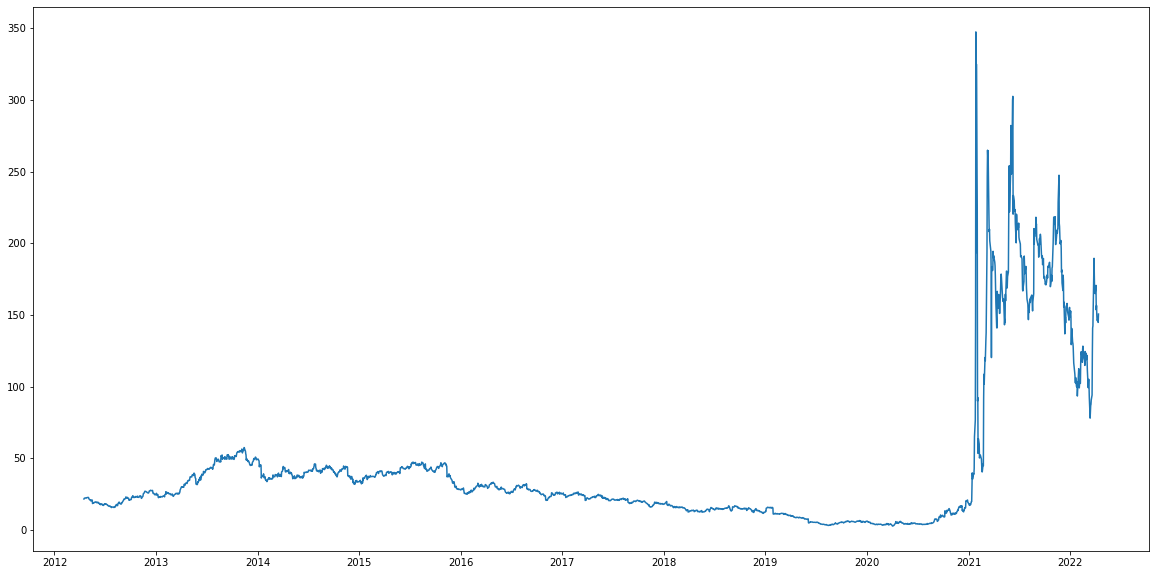

In [6]:
plt.plot(sub_df["Close"],label='GME Close Price history')

In [7]:
"""
LSTM Prediction Model
Adjust the data to train our model, LSTM
Long Short-Term Memory work great when making predictions based on time-series data sets
"""
sub_df = sub_df.sort_index(ascending=True, axis=0)
data = pd.DataFrame(index=range(0,len(df)),columns=["Date", "Close"])

for i in range(0,len(data)):
    data["Date"][i]=sub_df['Date'][i]
    data["Close"][i]=sub_df["Close"][i]
data.head()

,Date,Close
0,2012-04-16 00:00:00,21.7
1,2012-04-17 00:00:00,22.15
2,2012-04-18 00:00:00,22.29
3,2012-04-19 00:00:00,22.29
4,2012-04-20 00:00:00,22.38


In [8]:
# Min-Max Scaler
scaler=MinMaxScaler(feature_range=(0,1))

data.index=data.Date
data.drop("Date",axis=1,inplace=True)

final_data = data.values
train_data=final_data[0:200,:]
valid_data=final_data[200:,:]

scaler=MinMaxScaler(feature_range=(0,1))

scaled_data=scaler.fit_transform(final_data)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data = np.asarray(x_train_data)
y_train_data = np.asarray(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1],1))

In [9]:
#LSTM
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(np.shape(x_train_data)[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
model_data=data[len(data)-len(valid_data)-60:].values
model_data=model_data.reshape(-1,1)
model_data=scaler.transform(model_data)

In [10]:
#Train and Test Data
lstm_model.compile(loss="mean_squared_error",optimizer="adam")
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)
X_test=[]
for i in range(60,model_data.shape[0]):
    X_test.append(model_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

140/140 - 3s - loss: 1.1919e-04 - 3s/epoch - 23ms/step


In [11]:
# Prediction Function
predicted_stock_price=lstm_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)

C:\Users\JHanek\AppData\Local\Temp\ipykernel_3612\3061627311.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_stock_price


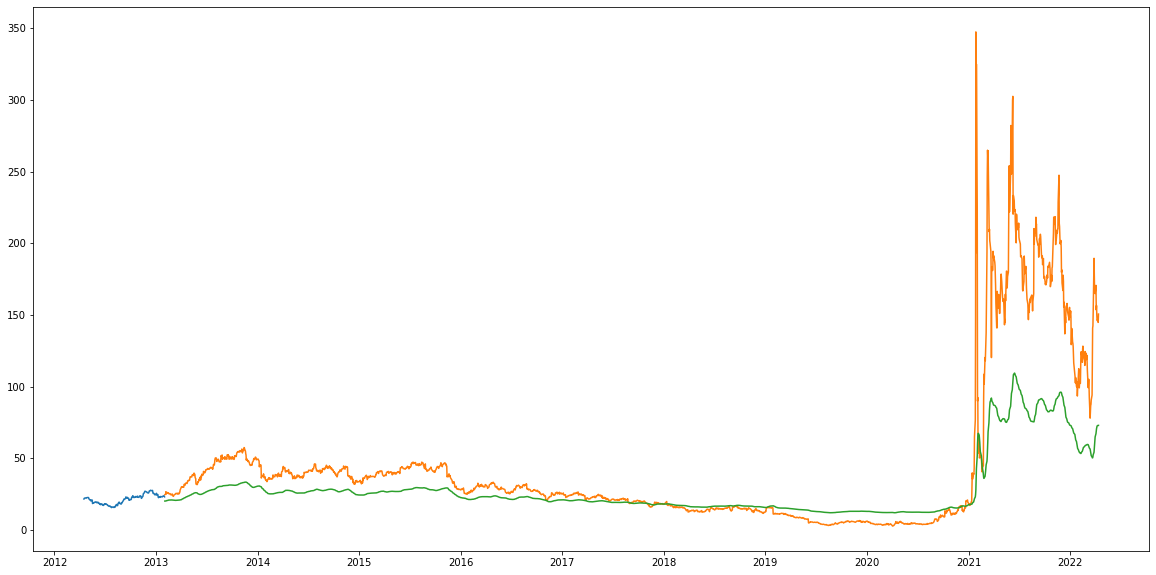

In [12]:
# Prediction Result

train_data=data[:200]
valid_data=data[200:]
valid_data['Predictions']=predicted_stock_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

In [13]:
# Closing thoughts, author didn't explain anything about predictions and why we do what we do
# Probably expected to copy and paste, so nothing of value was learned
# Also he never mentioned that he cut the data set to first 200